In [ ]:
import torch
import torchvision.models as models
import cv2
import numpy as np
import os
import time
from keras.preprocessing import image
import skimage.feature as sf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution3D, MaxPooling3D
import keras.optimizers as opt
from keras.utils import np_utils, generic_utils
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection  import train_test_split

from sklearn import preprocessing
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
def load_data(num_vids, num_frames, skipframes):
  
  parent_dir = '/content/drive/Shareddrives/Projects/Fall 2020 Projects/CV/Final Report/kth'
  parent_dir = os.path.abspath(parent_dir)
  
  frames_list = []
  Xtr=[]
  labels=[]
  vid_count = 0
  frame_count = 0
  
  act_classes=['boxing','handwaving','handclapping','jogging','running','walking']#jogging out

  for act_class in act_classes:
    vid_count = 0
    class_dir = os.path.join(parent_dir, act_class)
    vid_list = []
    for vid_file in os.listdir(class_dir):
      vid_count += 1
      if (vid_count<=num_vids):
        frames_list = []
        print ("IN: ",vid_file, vid_count)
        file = os.path.join(class_dir,vid_file)
        vid_cap = cv2.VideoCapture(file)
        success , frame = vid_cap.read()
        frame_count = 1

        #remove empty frames
        while success and frame_count<=num_frames:
          blurred_image = cv2.GaussianBlur(frame, (7,7), 0)  
          canny2 = cv2.Canny(blurred_image, 50, 150)          #edge detection

          while np.mean(canny2) == 0:
            success , frame = vid_cap.read()
            blurred_image = cv2.GaussianBlur(frame, (7,7), 0)  
            canny2 = cv2.Canny(blurred_image, 50, 150)   
          if (np.mean(canny2) != 0 and frame_count <= num_frames): # no edge means no character in frame
            norm = cv2.normalize(frame, None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            resized = cv2.resize(norm, (64,64), interpolation = cv2.INTER_AREA)
            resized=np.array(resized)
            x=resized.reshape((1,3,64,64))#/
            frames_list.append(x)#/x
            frame_count += 1
          
          for skip in range (0, skipframes):
            success , frame = vid_cap.read()
          while not success:
            success , frame = vid_cap.read()
        if frame_count!=(num_frames+1):
          print( vid_file, frame_count)

        Xtr.append(frames_list)
        labels.append(act_class)
  return Xtr,labels

In [ ]:
def feature_extractor():
  model = models.mobilenet_v2(pretrained=True)
  new_base =  (list(model.children())[:-1])[0]
  return new_base

def extract_features(Xtr,new_base):
  for i in Xtr:
    for j in i:
      x=torch.Tensor(j)
      output= new_base[:3](x)
      j=output
  return Xtr

def vgg16(Xtr):
  vgg16 = models.vgg16(pretrained=True)
  for i in Xtr:
    for j in i:
      x=torch.Tensor(j)  
      output = vgg16.features[:3](x)
      j=output
  return Xtr


In [ ]:
def hog_feat(frames):
  features = []
  hogX=[]
  for i in frames:
    for j in i:
      newj=j.reshape(64,64,3)
      fd, hog_image=(hog(newj,visualize=True, multichannel=True))
      hog_image=hog_image.reshape(1,64,64)
      features.append(hog_image)
    hogX.append(features)
    features=[]
  return hogX

In [ ]:
def preprocess(labels,Xtr, nb_classes,frames,channel):

  y=np.zeros(len(labels))
  act_classes=['boxing','handwaving','handclapping','jogging','running','walking']
  for i in range (0, len(y)):
    if labels[i] in act_classes:
      y[i]=act_classes.index(labels[i])
  
    # convert class vectors to binary class matrices
  Y_train = np_utils.to_categorical(y, nb_classes)
  
  Xtr_new=np.array(len(Xtr))
  Xtr_new=np.array(Xtr)
  print("Current shape:", Xtr_new.shape)
  Xtr_new=Xtr_new.reshape(598,channel,frames,64,64)
  print("New shape:", Xtr_new.shape)
  return Xtr_new,Y_train

In [ ]:
def NoCNNpreprocess(X,chanel,frames):
  Xnew=np.array(X)
  Xnew=Xnew.reshape(len(X),64*64*chanel*frames)
  print(Xnew.shape)
  return Xnew

In [ ]:
def rforest_model():
  clf = RandomForestClassifier(n_estimators=100, random_state=0)
  return clf

In [ ]:
# Define model
def kerasmod3(channel):

  model = Sequential()
  model.add(BatchNormalization())

  model.add(Convolution3D(8, 5, input_shape=(channel,25,64,64), activation='relu', data_format = 'channels_first'))
  model.add(Convolution3D(16, 3, activation='relu'))
  model.add(Convolution3D(32, 3, activation='relu'))

  model.add(Dropout(0.1))
  model.add(MaxPooling3D(pool_size=2))
  

  model.add(Dropout(0.1))

  model.add(Flatten())
  
  model.add(Dropout(0.1))

  model.add(Dense(128, kernel_initializer='normal', activation='relu'))

  model.add(Dense(6, kernel_initializer='normal'))

  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

  return model

In [ ]:
def main(feat,classmodel):
  
  act_classes=['boxing','handwaving','handclapping','jogging','running','walking']
  num_vids=100
  num_frames=25
  if classmodel=="rf":
    num_frames=10
  skipframes=2
  nb_classes =6
  channel=3
  #loading and preprocessing
  X,labels=load_data(num_vids, num_frames, skipframes)

  start=time.time()
  if feat=='MNet':
    new_base=feature_extractor()
    Xtr=extract_features(X,new_base)

  elif feat=='hog':
    Xtr=hog_feat(X)
    channel =1
  elif feat == 'vgg':
    Xtr=vgg16(X)

  Xtr_new, Y_train=preprocess(labels,Xtr,nb_classes,num_frames,channel)  
  
  if classmodel=="CNN":
    # CNN Training parameters
    X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(Xtr_new,Y_train, 
                                                                      test_size=0.2, random_state=21)
    # Train the model
    model=kerasmod3(channel)
    hist = model.fit(X_train_new, y_train_new, batch_size=  32, epochs = 20,shuffle=True) 
    #for loading already trained model please comment two lines of code above and uncomment the below 2 lines 
    #from keras.models import load_model
    #model= load_model('kth_model 76.67.h5')
    
    # Evaluate the model
    score = model.evaluate(X_val_new, y_val_new, batch_size=32)
    print('Test score:', score[0])
    print('Test accuracy:', score[1]) 
    model.save("kth_model.h5")
    y_val_new1 = [np.argmax(y, axis=None, out=None) for y in y_val_new]
    y_pred=model.predict_classes(X_val_new)
  
    con_mat = tf.math.confusion_matrix(labels=y_val_new1, predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,  index = act_classes,  columns = act_classes)
    print(con_mat_df)
    print(classification_report(y_val_new1,y_pred))

  else:
    X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(Xtr_new,labels, 
                                                                      test_size=0.2, random_state=21)
    train=NoCNNpreprocess(X_train_new,channel,num_frames)
    test=NoCNNpreprocess(X_val_new,channel,num_frames)
    
    model=rforest_model()

    hist = model.fit(train, y_train_new)#, batch_size=32, epochs=20, shuffle=True)
    # Evaluate the model
    y_pred = model.predict(test)
    accu = model.score(test, y_val_new)
    print("\t   Accuracy    : ", accu)
 
    print(classification_report(y_val_new,y_pred))
  
    con_mat = confusion_matrix(y_val_new, y_pred)
    
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,  index = act_classes,  columns = act_classes)
    print(con_mat_df)
    print(classification_report(y_val_new,y_pred))
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()  
  end=time.time()
  print("Runtime: ", end-start)

IN:  person01_boxing_d1_uncomp.avi 1
IN:  person01_boxing_d3_uncomp.avi 2
IN:  person01_boxing_d4_uncomp.avi 3
IN:  person02_boxing_d1_uncomp.avi 4
IN:  person01_boxing_d2_uncomp.avi 5
IN:  person02_boxing_d2_uncomp.avi 6
IN:  person02_boxing_d3_uncomp.avi 7
IN:  person03_boxing_d2_uncomp.avi 8
IN:  person07_boxing_d2_uncomp.avi 9
IN:  person06_boxing_d1_uncomp.avi 10
IN:  person05_boxing_d2_uncomp.avi 11
IN:  person04_boxing_d3_uncomp.avi 12
IN:  person06_boxing_d4_uncomp.avi 13
IN:  person04_boxing_d1_uncomp.avi 14
IN:  person05_boxing_d4_uncomp.avi 15
IN:  person04_boxing_d2_uncomp.avi 16
IN:  person06_boxing_d2_uncomp.avi 17
IN:  person03_boxing_d3_uncomp.avi 18
IN:  person04_boxing_d4_uncomp.avi 19
IN:  person05_boxing_d3_uncomp.avi 20
IN:  person07_boxing_d1_uncomp.avi 21
IN:  person06_boxing_d3_uncomp.avi 22
IN:  person07_boxing_d4_uncomp.avi 23
IN:  person07_boxing_d3_uncomp.avi 24
IN:  person03_boxing_d1_uncomp.avi 25
IN:  person03_boxing_d4_uncomp.avi 26
IN:  person02_boxing_

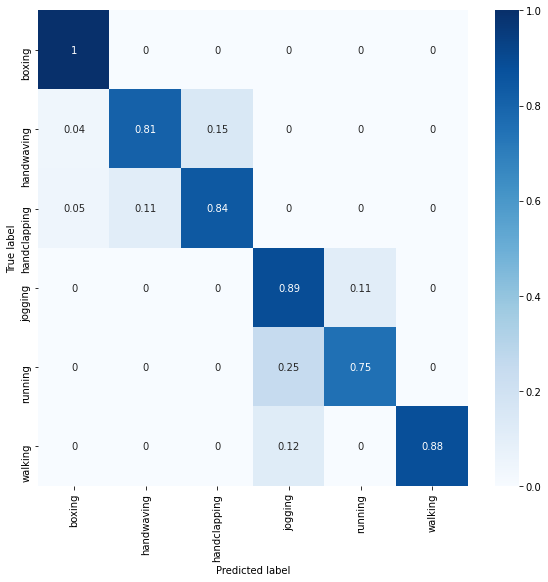

Runtime:  185.2620768547058


In [ ]:
if __name__ == "__main__":
    main('hog','CNN')

IN:  person01_boxing_d1_uncomp.avi 1
IN:  person01_boxing_d3_uncomp.avi 2
IN:  person01_boxing_d4_uncomp.avi 3
IN:  person02_boxing_d1_uncomp.avi 4
IN:  person01_boxing_d2_uncomp.avi 5
IN:  person02_boxing_d2_uncomp.avi 6
IN:  person02_boxing_d3_uncomp.avi 7
IN:  person03_boxing_d2_uncomp.avi 8
IN:  person07_boxing_d2_uncomp.avi 9
IN:  person06_boxing_d1_uncomp.avi 10
IN:  person05_boxing_d2_uncomp.avi 11
IN:  person04_boxing_d3_uncomp.avi 12
IN:  person06_boxing_d4_uncomp.avi 13
IN:  person04_boxing_d1_uncomp.avi 14
IN:  person05_boxing_d4_uncomp.avi 15
IN:  person04_boxing_d2_uncomp.avi 16
IN:  person06_boxing_d2_uncomp.avi 17
IN:  person03_boxing_d3_uncomp.avi 18
IN:  person04_boxing_d4_uncomp.avi 19
IN:  person05_boxing_d3_uncomp.avi 20
IN:  person07_boxing_d1_uncomp.avi 21
IN:  person06_boxing_d3_uncomp.avi 22
IN:  person07_boxing_d4_uncomp.avi 23
IN:  person07_boxing_d3_uncomp.avi 24
IN:  person03_boxing_d1_uncomp.avi 25
IN:  person03_boxing_d4_uncomp.avi 26
IN:  person02_boxing_

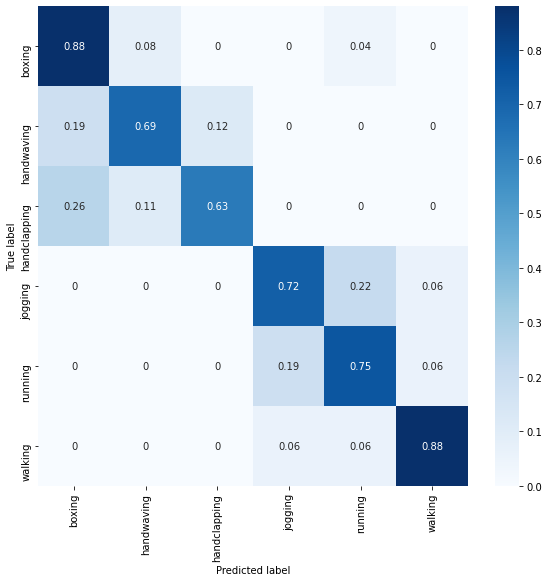

Runtime:  91.53660702705383


In [ ]:
if __name__ == "__main__":
    main('MNet','CNN')

IN:  person01_boxing_d1_uncomp.avi 1
IN:  person01_boxing_d3_uncomp.avi 2
IN:  person01_boxing_d4_uncomp.avi 3
IN:  person02_boxing_d1_uncomp.avi 4
IN:  person01_boxing_d2_uncomp.avi 5
IN:  person02_boxing_d2_uncomp.avi 6
IN:  person02_boxing_d3_uncomp.avi 7
IN:  person03_boxing_d2_uncomp.avi 8
IN:  person07_boxing_d2_uncomp.avi 9
IN:  person06_boxing_d1_uncomp.avi 10
IN:  person05_boxing_d2_uncomp.avi 11
IN:  person04_boxing_d3_uncomp.avi 12
IN:  person06_boxing_d4_uncomp.avi 13
IN:  person04_boxing_d1_uncomp.avi 14
IN:  person05_boxing_d4_uncomp.avi 15
IN:  person04_boxing_d2_uncomp.avi 16
IN:  person06_boxing_d2_uncomp.avi 17
IN:  person03_boxing_d3_uncomp.avi 18
IN:  person04_boxing_d4_uncomp.avi 19
IN:  person05_boxing_d3_uncomp.avi 20
IN:  person07_boxing_d1_uncomp.avi 21
IN:  person06_boxing_d3_uncomp.avi 22
IN:  person07_boxing_d4_uncomp.avi 23
IN:  person07_boxing_d3_uncomp.avi 24
IN:  person03_boxing_d1_uncomp.avi 25
IN:  person03_boxing_d4_uncomp.avi 26
IN:  person02_boxing_

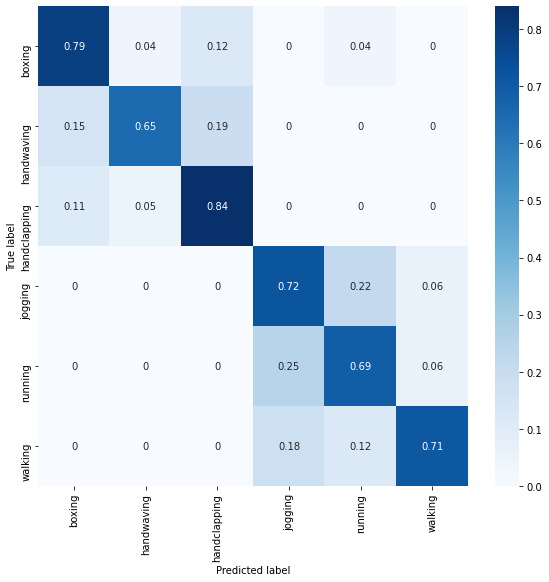

Runtime:  137.18778657913208


In [ ]:
  if __name__ == "__main__":
    main('vgg','CNN')

IN:  person01_boxing_d1_uncomp.avi 1
IN:  person01_boxing_d3_uncomp.avi 2
IN:  person01_boxing_d4_uncomp.avi 3
IN:  person02_boxing_d1_uncomp.avi 4
IN:  person01_boxing_d2_uncomp.avi 5
IN:  person02_boxing_d2_uncomp.avi 6
IN:  person02_boxing_d3_uncomp.avi 7
IN:  person03_boxing_d2_uncomp.avi 8
IN:  person07_boxing_d2_uncomp.avi 9
IN:  person06_boxing_d1_uncomp.avi 10
IN:  person05_boxing_d2_uncomp.avi 11
IN:  person04_boxing_d3_uncomp.avi 12
IN:  person06_boxing_d4_uncomp.avi 13
IN:  person04_boxing_d1_uncomp.avi 14
IN:  person05_boxing_d4_uncomp.avi 15
IN:  person04_boxing_d2_uncomp.avi 16
IN:  person06_boxing_d2_uncomp.avi 17
IN:  person03_boxing_d3_uncomp.avi 18
IN:  person04_boxing_d4_uncomp.avi 19
IN:  person05_boxing_d3_uncomp.avi 20
IN:  person07_boxing_d1_uncomp.avi 21
IN:  person06_boxing_d3_uncomp.avi 22
IN:  person07_boxing_d4_uncomp.avi 23
IN:  person07_boxing_d3_uncomp.avi 24
IN:  person03_boxing_d1_uncomp.avi 25
IN:  person03_boxing_d4_uncomp.avi 26
IN:  person02_boxing_

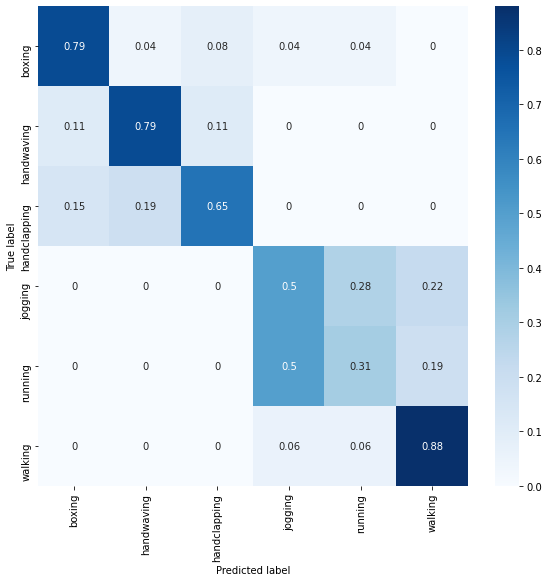

Runtime:  71.08379244804382


In [ ]:
if __name__ == "__main__":
    main('hog','rf')

IN:  person01_boxing_d1_uncomp.avi 1
IN:  person01_boxing_d3_uncomp.avi 2
IN:  person01_boxing_d4_uncomp.avi 3
IN:  person02_boxing_d1_uncomp.avi 4
IN:  person01_boxing_d2_uncomp.avi 5
IN:  person02_boxing_d2_uncomp.avi 6
IN:  person02_boxing_d3_uncomp.avi 7
IN:  person03_boxing_d2_uncomp.avi 8
IN:  person07_boxing_d2_uncomp.avi 9
IN:  person06_boxing_d1_uncomp.avi 10
IN:  person05_boxing_d2_uncomp.avi 11
IN:  person04_boxing_d3_uncomp.avi 12
IN:  person06_boxing_d4_uncomp.avi 13
IN:  person04_boxing_d1_uncomp.avi 14
IN:  person05_boxing_d4_uncomp.avi 15
IN:  person04_boxing_d2_uncomp.avi 16
IN:  person06_boxing_d2_uncomp.avi 17
IN:  person03_boxing_d3_uncomp.avi 18
IN:  person04_boxing_d4_uncomp.avi 19
IN:  person05_boxing_d3_uncomp.avi 20
IN:  person07_boxing_d1_uncomp.avi 21
IN:  person06_boxing_d3_uncomp.avi 22
IN:  person07_boxing_d4_uncomp.avi 23
IN:  person07_boxing_d3_uncomp.avi 24
IN:  person03_boxing_d1_uncomp.avi 25
IN:  person03_boxing_d4_uncomp.avi 26
IN:  person02_boxing_

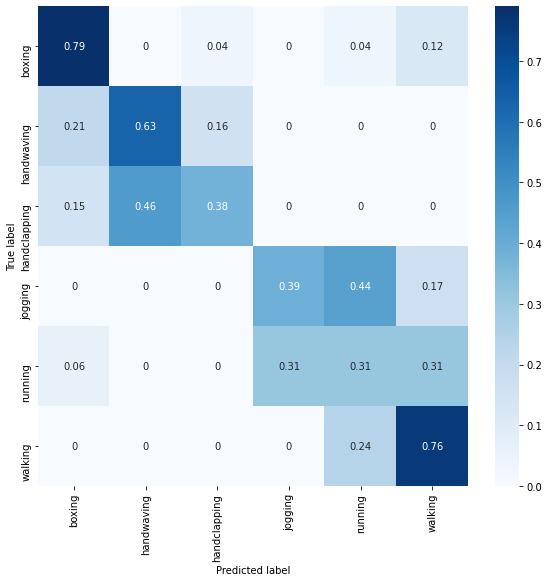

Runtime:  35.4378023147583


In [ ]:
if __name__ == "__main__":
    main('MNet','rf')

IN:  person01_boxing_d1_uncomp.avi 1
IN:  person01_boxing_d3_uncomp.avi 2
IN:  person01_boxing_d4_uncomp.avi 3
IN:  person02_boxing_d1_uncomp.avi 4
IN:  person01_boxing_d2_uncomp.avi 5
IN:  person02_boxing_d2_uncomp.avi 6
IN:  person02_boxing_d3_uncomp.avi 7
IN:  person03_boxing_d2_uncomp.avi 8
IN:  person07_boxing_d2_uncomp.avi 9
IN:  person06_boxing_d1_uncomp.avi 10
IN:  person05_boxing_d2_uncomp.avi 11
IN:  person04_boxing_d3_uncomp.avi 12
IN:  person06_boxing_d4_uncomp.avi 13
IN:  person04_boxing_d1_uncomp.avi 14
IN:  person05_boxing_d4_uncomp.avi 15
IN:  person04_boxing_d2_uncomp.avi 16
IN:  person06_boxing_d2_uncomp.avi 17
IN:  person03_boxing_d3_uncomp.avi 18
IN:  person04_boxing_d4_uncomp.avi 19
IN:  person05_boxing_d3_uncomp.avi 20
IN:  person07_boxing_d1_uncomp.avi 21
IN:  person06_boxing_d3_uncomp.avi 22
IN:  person07_boxing_d4_uncomp.avi 23
IN:  person07_boxing_d3_uncomp.avi 24
IN:  person03_boxing_d1_uncomp.avi 25
IN:  person03_boxing_d4_uncomp.avi 26
IN:  person02_boxing_

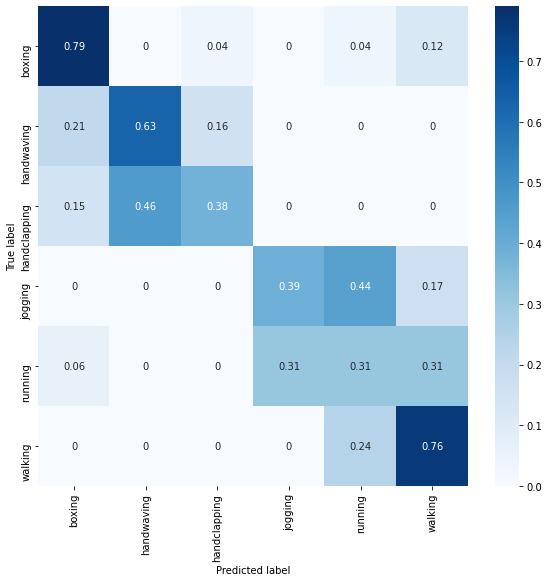

Runtime:  58.0797119140625


In [ ]:
if __name__ == "__main__":
    main('vgg','rf')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
